100 = 50 / 50   p1= 0.5

100 = 90/10   p1=0.9

100 = 10/100  p1=0.1

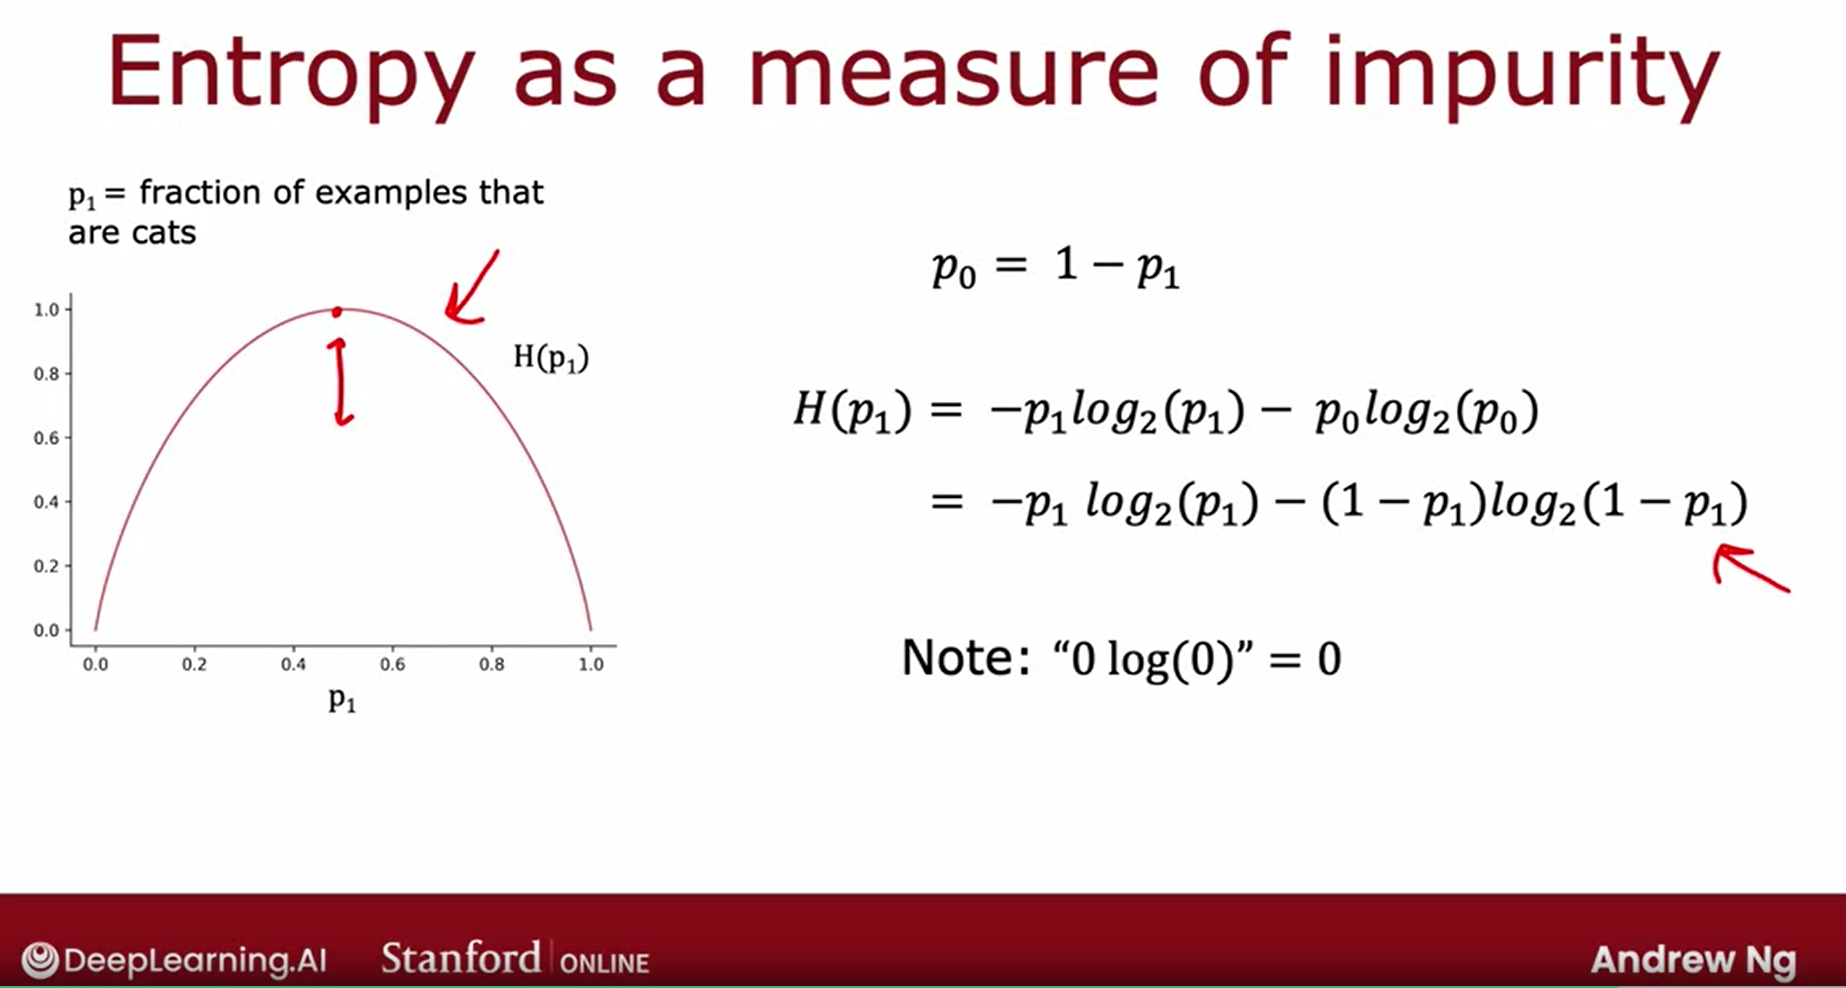

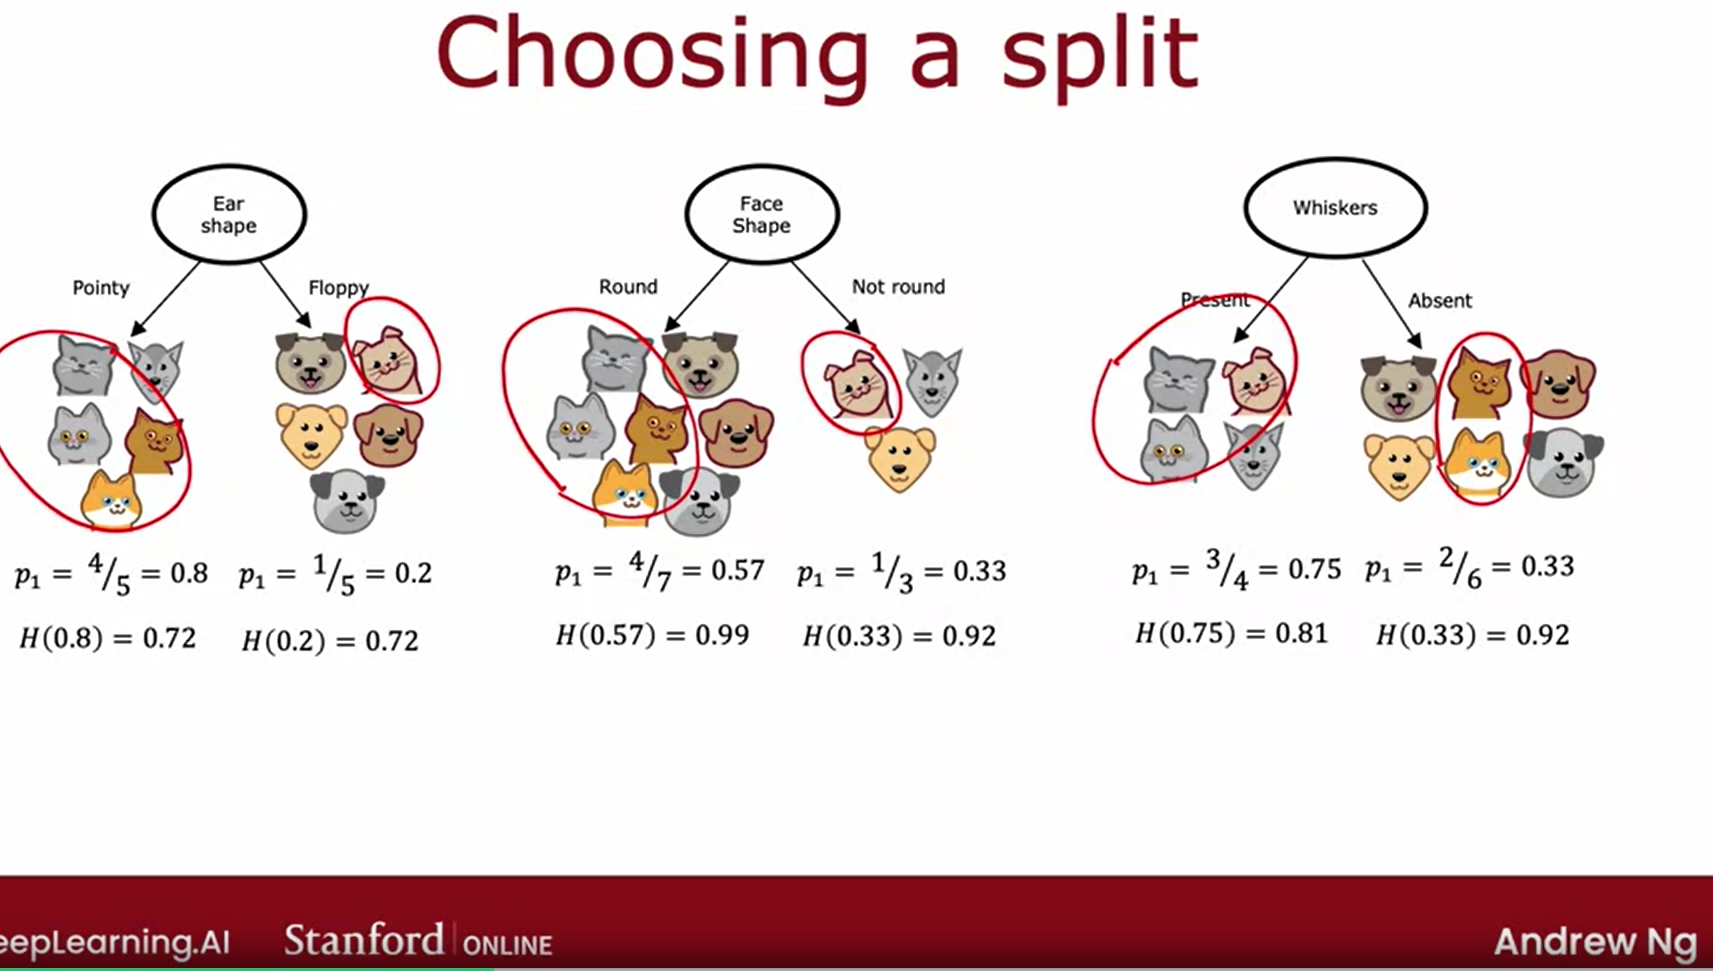

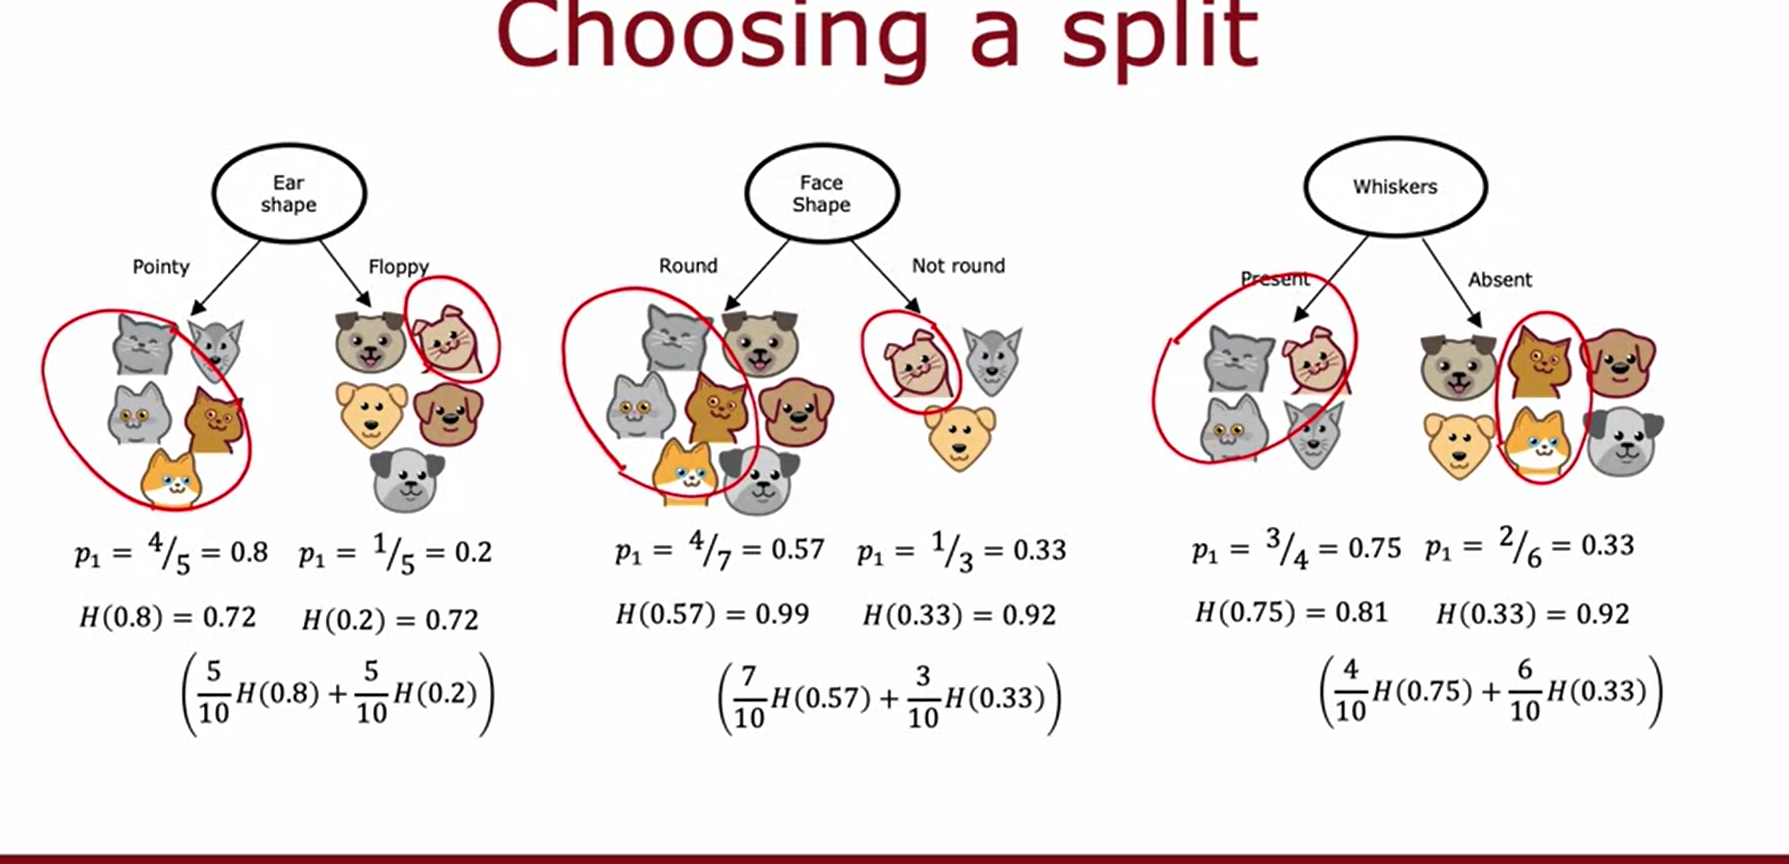

###PICK THE ONE WITH THE LOWEST AVERAGE WEIGHTED ENTROPY

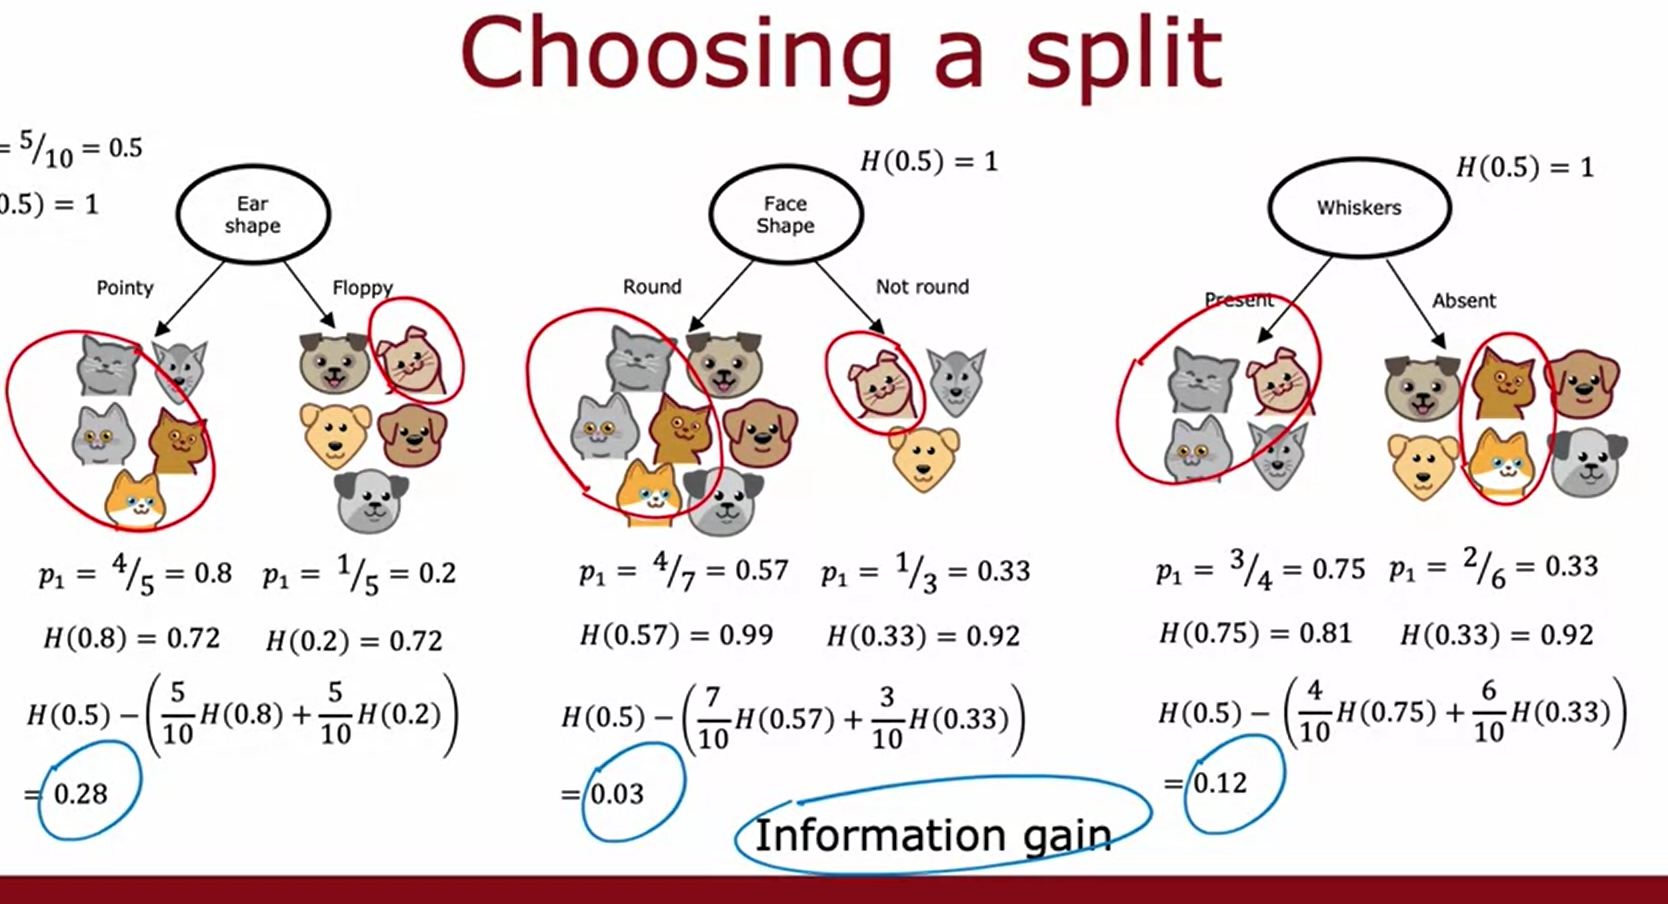

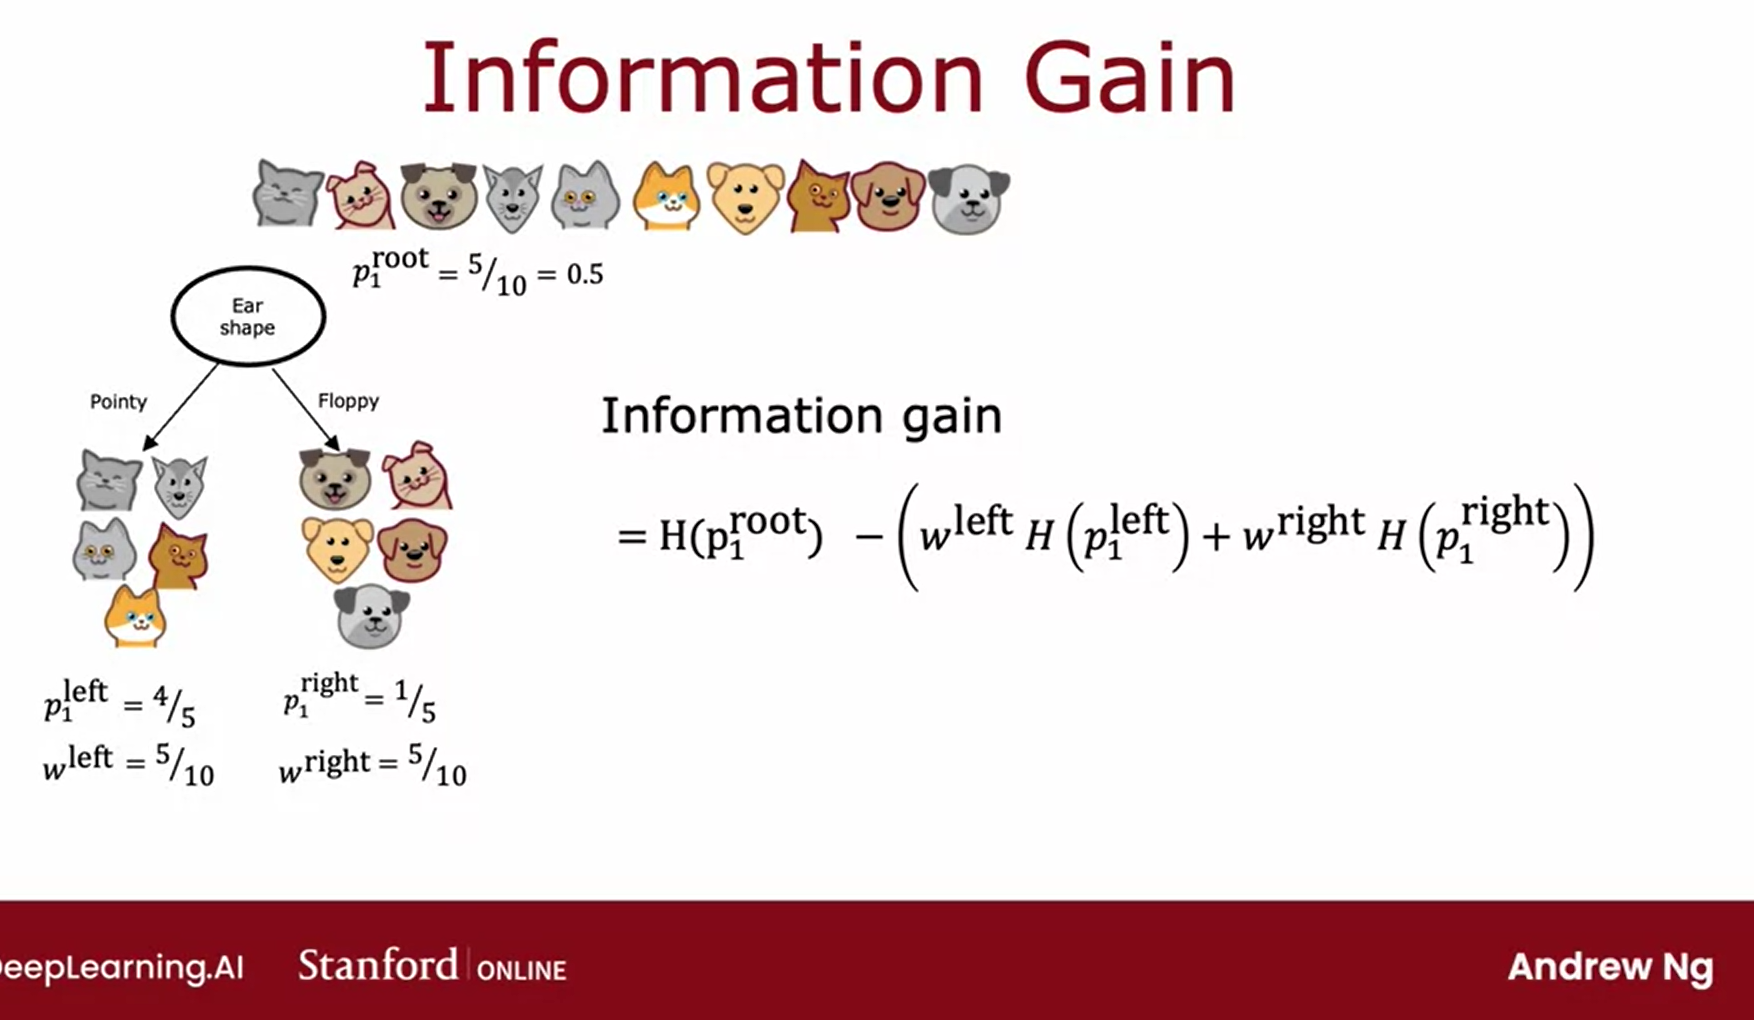

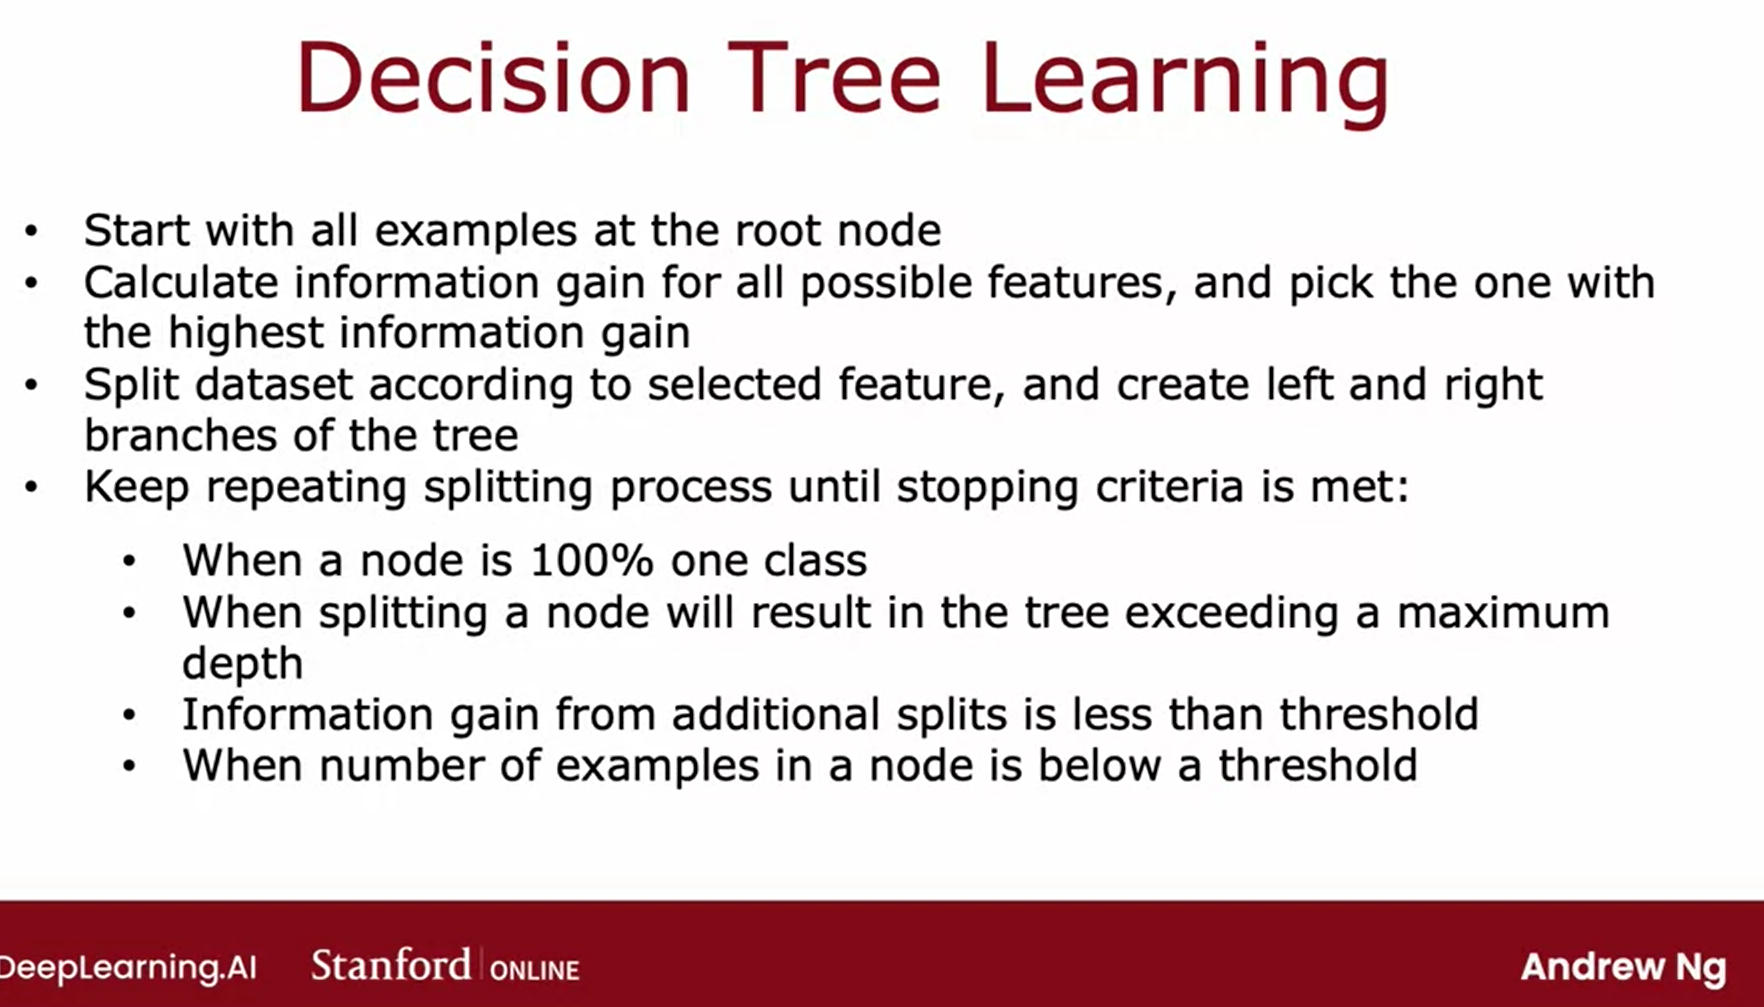

##DECISION TREES FOR REGRESSION:  PREDICTING A NUMBER

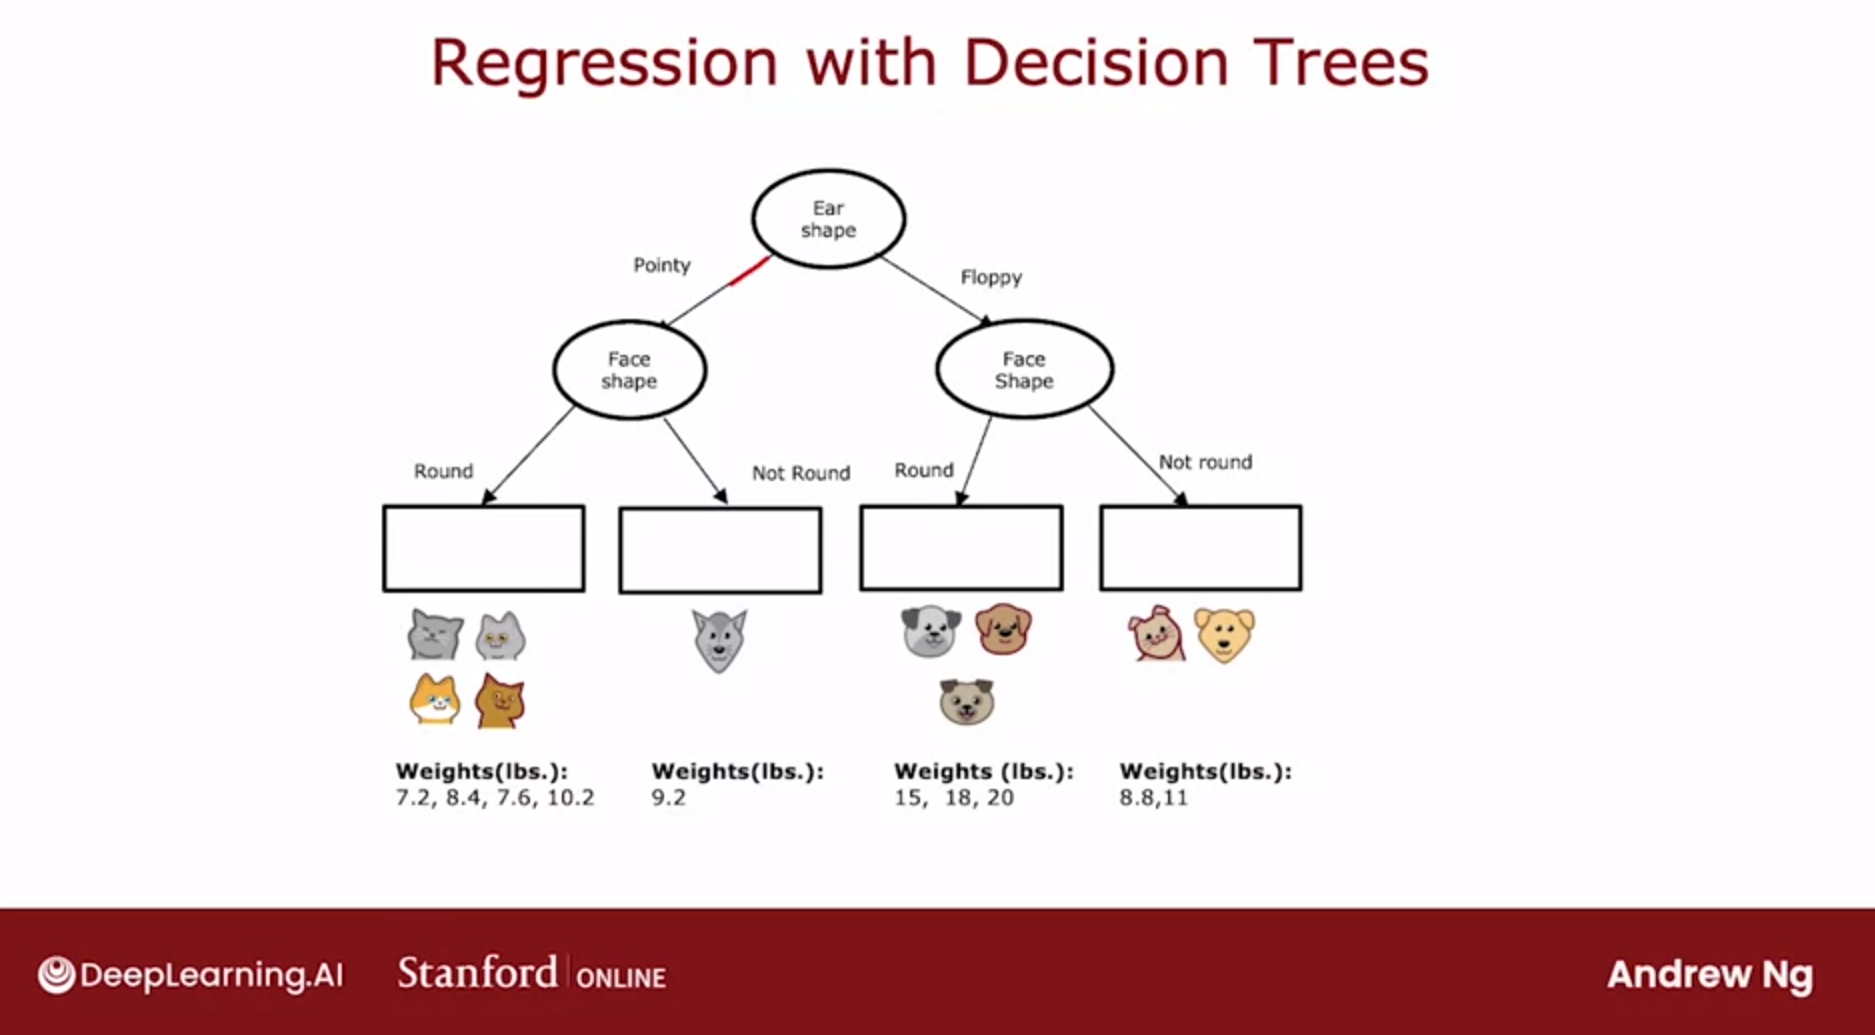

As you saw in the lectures, in a decision tree, we decide if a node will be split or not by looking at the **information gain** that split would give us. (Image of video IG)

Where

$$\text{Information Gain} = H(p_1^\text{node})- \left(w^{\text{left}}H\left(p_1^\text{left}\right) + w^{\text{right}}H\left(p_1^\text{right}\right)\right),$$

and $H$ is the entropy, defined as

$$H(p_1) = -p_1 \text{log}_2(p_1) - (1- p_1) \text{log}_2(1- p_1)$$

Remember that log here is defined to be in base 2. Run the code block below to see by yourself how the entropy. $H(p)$ behaves while $p$ varies.

Note that the H attains its higher value when $p = 0.5$. This means that the probability of event is $0.5$. And its minimum value is attained in $p = 0$ and $p = 1$, i.e., the probability of the event happening is totally predictable. Thus, the entropy shows the degree of predictability of an event.

In [1]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
from matplotlib.widgets import Slider, Button

ModuleNotFoundError: No module named 'networkx'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install ipympl

In [7]:
import ipympl

##WE DEFINE THE UTILS

In [8]:
from PIL import Image
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
from matplotlib.widgets import Slider, Button

In [9]:
def compute_entropy(y):
    entropy = 0

    if len(y) == 0:
      return 0
    entropy = sum(y[y==1]/len(y))
    if entropy == 0 or entropy ==1:
      return 0
    else:
      return -entropy*np.log2(entropy)-(1-entropy)*np.log2(1-entropy)

def split_dataset(X, node_indices, feature):
    left_indices = []
    right_indices = []

    for i in node_indices:
      if X[i][feature]==1:
        left_indices.append(i)
      else:
        right_indices.append(i)
    return left_indices, right_indices

def compute_information_gain(X, y, node_indices, feature):
    """this function receives X values and y targets, node_indices and the features(future nodes)"""
    left_indices, right_indices = split_dataset(X, node_indices, feature)

    X_node, y_node = X[node_indices], y[node_indices]
    X_left, y_left = X[left_indices], y[left_indices]
    X_right, y_right = X[right_indices], y[right_indices]

    information_gain= 0

    node_entropy = compute_entropy(y_node)
    left_entropy = compute_entropy(y_left)
    right_entropy = compute_entropy(y_right)
    w_left = len(X_left)/len(X_node)
    w_right = len(X_right)/len(X_node)
    weighted_entropy = (w_left * left_entropy) + (w_right * right_entropy)
    information_gain = node_entropy - weighted_entropy

    return information_gain

def get_best_split(X, y, node_indices):
    num_features = X.shape[1]

    best_feature = -1

    max_info_gain = 0
    for feature in range(num_features):
      info_gain = compute_information_gain(X, y, node_indices, feature)
      if info_gain > max_info_gain:
        max_info_gain = info_gain
        best_feature = feature
    return best_feature



def build_tree_recursive(X, y, node_indices, branch_name, max_depth, current_depth, tree):

    if current_depth == max_depth:
        formatting = " "*current_depth + "-"*current_depth
        print(formatting, "%s leaf node with indices" % branch_name, node_indices)
        return

    best_feature = get_best_split(X, y, node_indices)

    formatting = "-"*current_depth
    print("%s Depth %d, %s: Split on feature: %d" % (formatting, current_depth, branch_name, best_feature))


    left_indices, right_indices = split_dataset(X, node_indices, best_feature)
    tree.append((left_indices, right_indices, best_feature))

    build_tree_recursive(X, y, left_indices, "Left", max_depth, current_depth+1, tree)
    build_tree_recursive(X, y, right_indices, "Right", max_depth, current_depth+1, tree)
    return tree

def generate_node_image(node_indices):
    image_paths = ["images/%d.png" % idx for idx in node_indices]
    images = [Image.open(x) for x in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im = new_im.resize((int(total_width*len(node_indices)/10), int(max_height*len(node_indices)/10)))

    return new_im


def generate_split_viz(node_indices, left_indices, right_indices, feature):

    G=nx.DiGraph()

    indices_list = [node_indices, left_indices, right_indices]
    for idx, indices in enumerate(indices_list):
        G.add_node(idx,image= generate_node_image(indices))

    G.add_edge(0,1)
    G.add_edge(0,2)

    pos = graphviz_layout(G, prog="dot")

    fig=plt.figure()
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax, arrows=True, arrowsize=40)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    feature_name = ["Ear Shape", "Face Shape", "Whiskers"][feature]
    ax_name = ["Splitting on %s" % feature_name , "Left: %s = 1" % feature_name, "Right: %s = 0" % feature_name]
    for idx, n in enumerate(G):
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        piesize = len(indices_list[idx])/9
        p2=piesize/2.0
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.axis('off')
        a.set_title(ax_name[idx])
    ax.axis('off')
    plt.show()


def generate_tree_viz(root_indices, y, tree):

    G=nx.DiGraph()


    G.add_node(0,image= generate_node_image(root_indices))
    idx = 1
    root = 0

    num_images = [len(root_indices)]

    feature_name = ["Ear Shape", "Face Shape", "Whiskers"]
    y_name = ["Non Cat","Cat"]

    decision_names = []
    leaf_names = []

    for i, level in enumerate(tree):
        indices_list = level[:2]
        for indices in indices_list:
            G.add_node(idx,image= generate_node_image(indices))
            G.add_edge(root, idx)

            # For visualization
            num_images.append(len(indices))
            idx += 1
            if i > 0:
                leaf_names.append("Leaf node: %s" % y_name[max(y[indices])])

        decision_names.append("Split on: %s" % feature_name[level[2]])
        root += 1


    node_names = decision_names + leaf_names
    pos = graphviz_layout(G, prog="dot")

    fig=plt.figure(figsize=(14, 10))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G,pos,ax=ax, arrows=True, arrowsize=40)

    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform

    for idx, n in enumerate(G):
        xx,yy=trans(pos[n]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        piesize = num_images[idx]/25
        p2=piesize/2.0
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.axis('off')
        try:
            a.set_title(node_names[idx], y=-0.8, fontsize=13, loc="left")
        except:
            pass
    ax.axis('off')
    plt.show()

def plot_entropy():
    def entropy(p):
        if p == 0 or p == 1:
            return 0
        else:
            return -p * np.log2(p) - (1- p)*np.log2(1 - p)
    p_array = np.linspace(0,1,201)
    h_array = [entropy(p) for p in p_array]
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    ax.set_title('p x H(p)')
    ax.set_xlabel('p')
    ax.set_ylabel('H(p)')
    axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])
    h_plot = ax.plot(p_array,h_array)
    scatter = ax.scatter(0,0,color = 'red', zorder = 100, s = 70)
    slider = Slider(axfreq, 'p', 0, 1, valinit = 0, valstep = 0.05)

    def update(val):
        x = val
        y = entropy(x)
        scatter.set_offsets((x,y))

    slider.on_changed(update)
    return slider
    #plt.plot()

In [10]:
from google.colab import output
output.enable_custom_widget_manager()

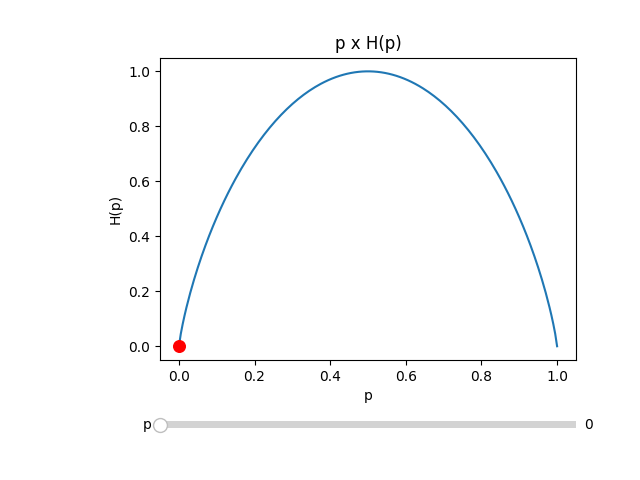

In [11]:
%matplotlib widget
_ = plot_entropy()

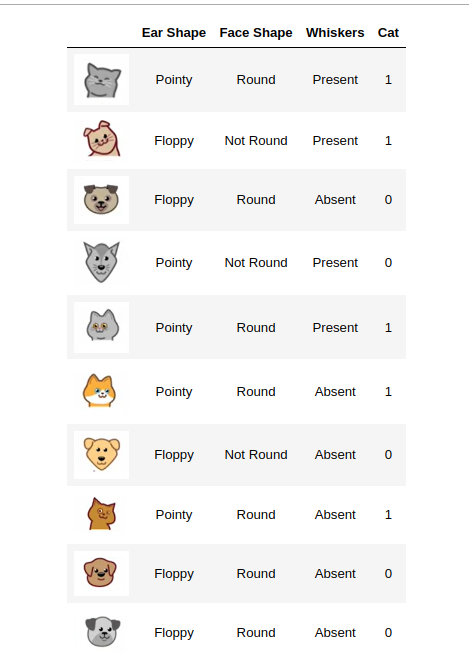


We will use **one-hot encoding** to encode the categorical features. They will be as follows:

- Ear Shape: Pointy = 1, Floppy = 0
- Face Shape: Round = 1, Not Round = 0
- Whiskers: Present = 1, Absent = 0

Therefore, we have two sets:

- `X_train`: for each example, contains 3 features:
            - Ear Shape (1 if pointy, 0 otherwise)
            - Face Shape (1 if round, 0 otherwise)
            - Whiskers (1 if present, 0 otherwise)
            
- `y_train`: whether the animal is a cat
            - 1 if the animal is a cat
            - 0 otherwise

In [12]:
X_train = np.array([[1, 1, 1],
[0, 0, 1],
 [0, 1, 0],
 [1, 0, 1],
 [1, 1, 1],
 [1, 1, 0],
 [0, 0, 0],
 [1, 1, 0],
 [0, 1, 0],
 [0, 1, 0]])

y_train = np.array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [13]:
#For instance, the first example
X_train[0]

array([1, 1, 1])

This means that the first example has a pointy ear shape, round face shape and it has whiskers.

On each node, we compute the information gain for each feature, then split the node on the feature with the higher information gain, by comparing the entropy of the node with the weighted entropy in the two splitted nodes.

So, the root node has every animal in our dataset. Remember that $p_1^{node}$ is the proportion of positive class (cats) in the root node. So

$$p_1^{node} = \frac{5}{10} = 0.5$$

Now let's write a function to compute the entropy.

In [14]:
def entropy(p):
  if p == 0 or p==1:
    return 0
  else:
    return -p * np.log2(p) -(1-p)* np.log2(1-p)

print(f'entropy when p=1, {entropy(1)}')
print(f'entropy when p=0, {entropy(1)}')
print(f'entropy when p=0.5, {entropy(0.5)}')
print(f'entropy when p=0.2,{entropy(0.2)}')
print(f'entropy when p=0.8,{entropy(0.8)}')

entropy when p=1, 0
entropy when p=0, 0
entropy when p=0.5, 1.0
entropy when p=0.2,0.7219280948873623
entropy when p=0.8,0.7219280948873623


To illustrate, let's compute the information gain if we split the node for each of the features. To do this, let's write some functions.

In [15]:
def split_indices(X, index_feature):
  """Given a dataset and a index feature, return two lists for the two split nodes, the left node has the animals that
  feature = 1 and the right node those that have the feature = 0
  index feature = 0 => ear shape
  index feature 1 => face shape
  index feature 2 => whiskers"""
  left_indices = []
  right_indices = []
  for i, x in enumerate(X):
      if x[index_feature] == 1:
          left_indices.append(i)
      else:
          right_indices.append(i)
  return left_indices, right_indices

so, if we chose Ear shape to split, then we must have in the left node, the indices

$$0 \quad 3 \quad 4 \quad 5 \quad 7$$

In [16]:
split_indices(X_train,0)

([0, 3, 4, 5, 7], [1, 2, 6, 8, 9])

Now we need another function to compute the weighted entropy in the splitted nodes. As you've seen in the video lecture, we must find:

- $w^{\text{left}}$ and $w^{\text{right}}$, the proportion of animals in **each node**.
- $p^{\text{left}}$ and $p^{\text{right}}$, the proportion of cats in **each split**.

Note the difference between these two definitions!! To illustrate, if we split the root node on the feature of index 0 (Ear Shape), then in the left node, the one that has the animals 0, 3, 4, 5 and 7, we have:

$$w^{\text{left}}= \frac{5}{10} = 0.5 \text{ and } p^{\text{left}} = \frac{4}{5}$$
$$w^{\text{right}}= \frac{5}{10} = 0.5 \text{ and } p^{\text{right}} = \frac{1}{5}$$

In [17]:
def weighted_entropy(X,y,left_indices,right_indices):
    """
    This function takes the splitted dataset, the indices we chose to split and returns the weighted entropy.
    """
    w_left = len(left_indices)/len(X)
    w_right = len(right_indices)/len(X)
    p_left = sum(y[left_indices])/len(left_indices)
    p_right = sum(y[right_indices])/len(right_indices)

    weighted_entropy = w_left * entropy(p_left) + w_right * entropy(p_right)
    return weighted_entropy

In [18]:
left_indices, right_indices = split_indices(X_train, 0)
weighted_entropy(X_train, y_train, left_indices, right_indices)

0.7219280948873623

In [19]:
def information_gain(X, y, left_indices, right_indices):
    """
    Here, X has the elements in the node and y is theirs respectives classes
    """
    p_node = sum(y)/len(y)
    h_node = entropy(p_node)
    w_entropy = weighted_entropy(X,y,left_indices,right_indices)
    return h_node - w_entropy

In [20]:
information_gain(X_train, y_train, left_indices, right_indices)

0.2780719051126377

In [21]:
for i, feature_name in enumerate(['Ear Shape', 'Face Shape', 'Whiskers']):
    left_indices, right_indices = split_indices(X_train, i)
    i_gain = information_gain(X_train, y_train, left_indices, right_indices)
    print(f"Feature: {feature_name}, information gain if we split the root node using this feature: {i_gain:.2f}")


Feature: Ear Shape, information gain if we split the root node using this feature: 0.28
Feature: Face Shape, information gain if we split the root node using this feature: 0.03
Feature: Whiskers, information gain if we split the root node using this feature: 0.12


The process is **recursive**, which means we must perform these calculations for each node until we meet a stopping criteria:

- If the tree depth after splitting exceeds a threshold
- If the resulting node has only 1 class
- If the information gain of splitting is below a threshold

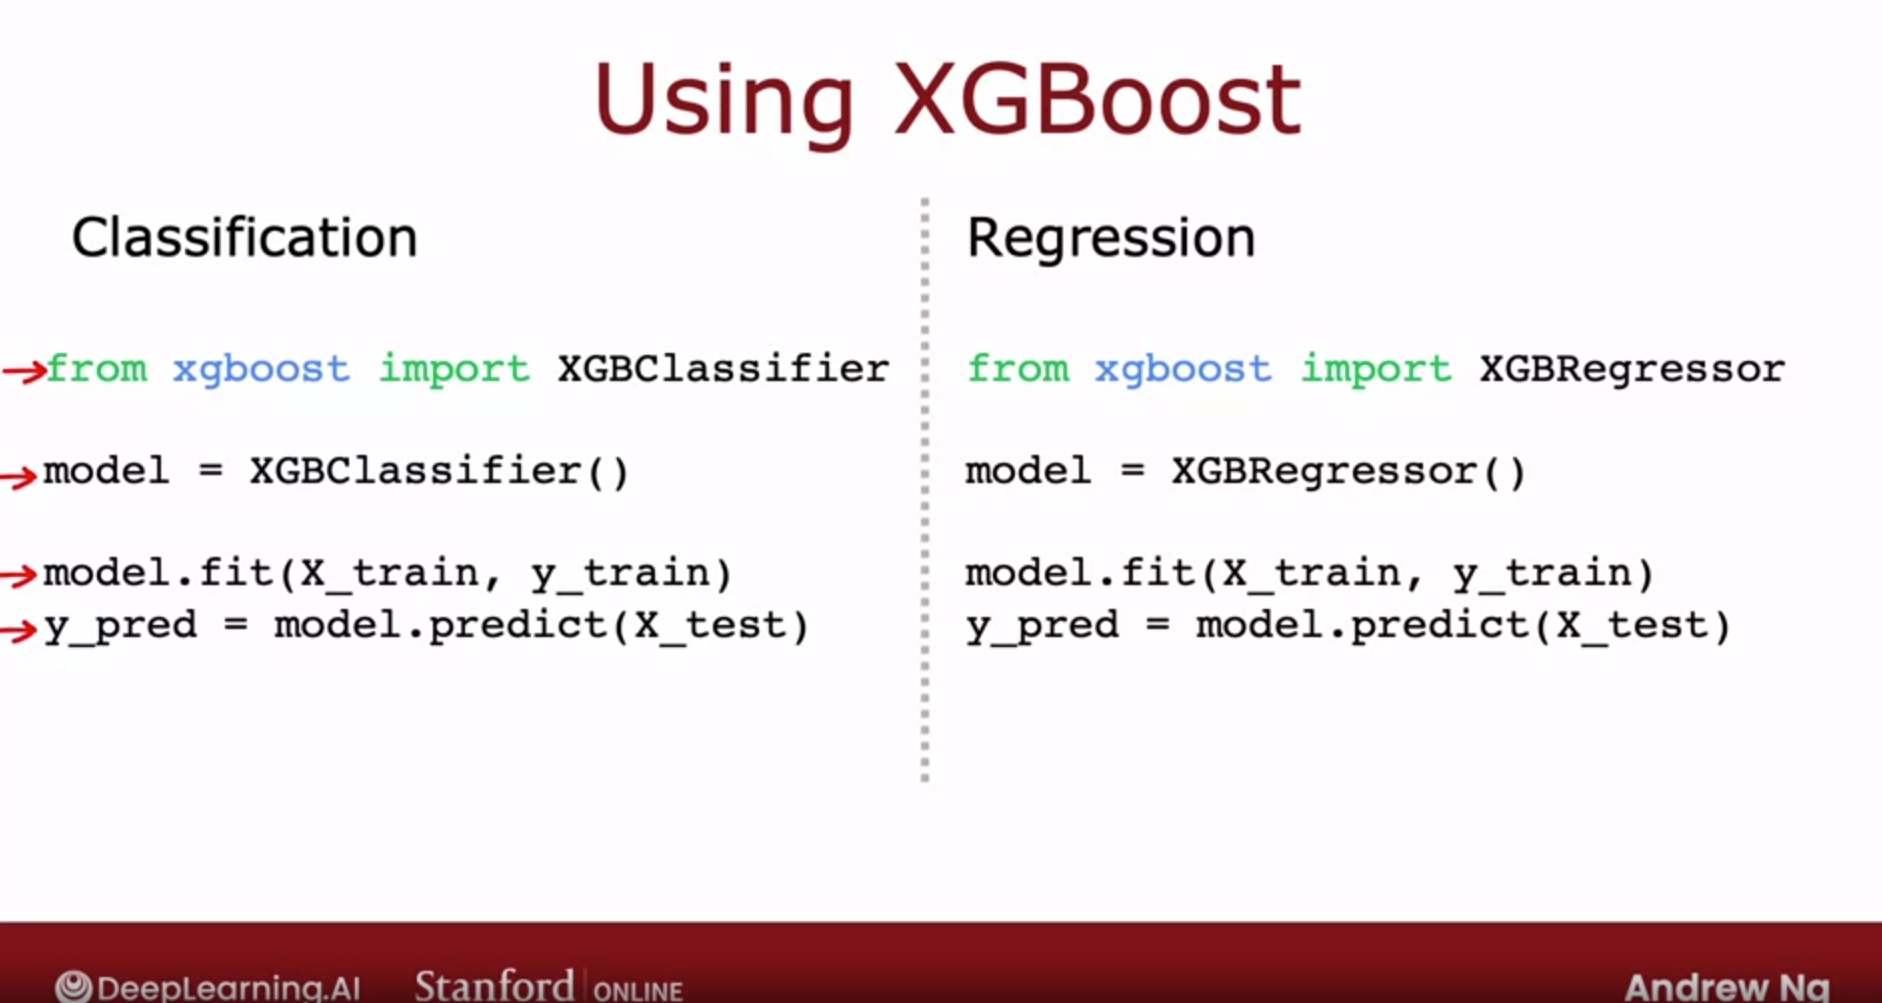

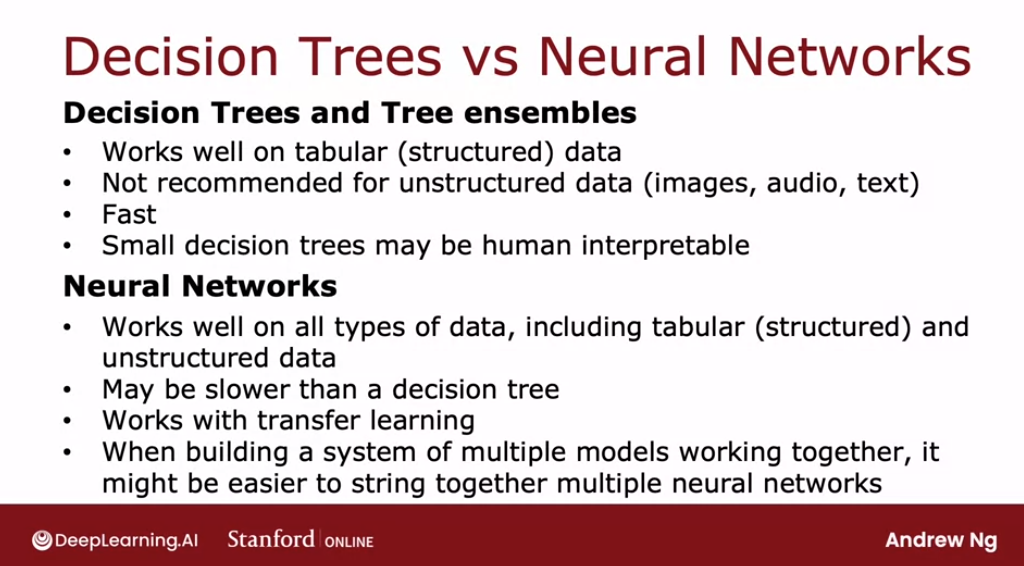